In [6]:
"""
Rabi angle for fluxonium under a resonant square pulse (direct numerical method).

We diagonalize the fluxonium Hamiltonian in the phase basis (finite differences),
compute n01 = <0|n̂|1>, and use the RWA two-level result:

    θ = k * V0 * t,   with   k = (2e * η / ħ) * |n01|

where:
- θ is the rotation angle in radians (e.g., π/2 for a π/2 pulse),
- V0 is the peak voltage of the drive at the qubit (Volts),
- t is the pulse duration (seconds),
- η is the voltage division factor (0..1).

All fluxonium energies are in GHz (E/h). Outputs for k are in rad/(V·s).
"""

from __future__ import annotations
import numpy as np
from dataclasses import dataclass
from scipy.sparse import diags
from scipy.sparse.linalg import eigsh

# --- SI constants ---
_E = 1.602176634e-19      # C
_HBAR = 1.054571817e-34   # J*s


@dataclass
class Spectrum:
    energies_ghz: np.ndarray      # shape (M,)
    states: np.ndarray            # shape (grid, M)
    n_op: np.ndarray              # (grid, grid)


# ---------- Fluxonium solver (phase-basis, finite differences) ----------
def solve_fluxonium(EC, EJ, EL, phi_ext, phi_max=10*np.pi, grid=2000, n_levels=4) -> Spectrum:
    """Return (energies, eigenvectors, n-operator) for fluxonium. Energies in GHz."""
    phi = np.linspace(-phi_max, phi_max, grid)
    dphi = phi[1] - phi[0]

    # -4 EC d^2/dphi^2
    main, off = 2.0*np.ones(grid), -1.0*np.ones(grid-1)
    d2 = diags([off, main, off], [-1, 0, 1]) / (dphi**2)
    kinetic = -4.0 * EC * d2

    # Potential: 1/2 EL (phi)^2 - EJ cos(phi-phi_ext)
    V = 0.5*EL*(phi**2) - EJ*np.cos(phi - phi_ext)
    H = kinetic + diags(V, 0)

    vals, vecs = eigsh(H, k=n_levels, which="SA")
    idx = np.argsort(vals)
    E = np.array(vals[idx])
    psi = np.array(vecs[:, idx])

    # n̂ = -i d/dφ (central difference, Dirichlet-like at edges)
    offp =  np.ones(grid-1) / (2.0*dphi)
    offm = -np.ones(grid-1) / (2.0*dphi)
    d1 = diags([offm, np.zeros(grid), offp], [-1, 0, 1]).toarray()
    n_op = (-1j) * d1

    return Spectrum(energies_ghz=E, states=psi, n_op=n_op)


# ---------- Rabi coefficient k, angle, and solvers ----------
def rabi_coefficient(EC, EJ, EL, phi_ext, eta, *, phi_max=10*np.pi, grid=2000) -> dict:
    """
    Compute |n01| and k = (e*eta/ħ) * |n01|  so that  θ = k * V0 * t  (radians).

    Parameters
    ----------
    EC, EJ, EL : float
        Fluxonium energies in GHz (E/h).
    phi_ext : float
        Reduced flux in radians (2π * Φ_ext / Φ0).
    eta : float
        Voltage-division factor (0..1) from drive to qubit island.
    phi_max, grid : discretization controls.

    Returns
    -------
    dict with keys:
        n01_abs : float
            |<0|n̂|1>|.
        k_rad_per_Vs : float
            Rabi coefficient k in rad/(V·s) for peak voltage V0.
        note : str
            Reminder about assumptions (resonant square pulse, RWA).
    """
    spec = solve_fluxonium(EC, EJ, EL, phi_ext, phi_max=phi_max, grid=grid, n_levels=2)
    psi = spec.states
    n_mat = spec.n_op
    n_mn = psi.conj().T @ (n_mat @ psi)    # matrix in eigenbasis
    n01 = n_mn[0, 1]
    k = (2*_E * eta / _HBAR) * np.abs(n01)   # rad/(V·s)  for peak V0

    return {
        "n01_abs": float(np.abs(n01)),
        "k_rad_per_Vs": float(k),
        "note": "θ = k * V0 * t (peak V0), resonant square pulse, RWA.",
    }


def rotation_angle(k_rad_per_Vs: float, V0_volt: float, t_sec: float, *, use_vrms=False) -> float:
    """
    θ = k * V * t. If you pass V_rms, set use_vrms=True (θ increases by √2).
    """
    V_eff = V0_volt if not use_vrms else (np.sqrt(2.0) * V0_volt)
    return k_rad_per_Vs * V_eff * t_sec


def solve_for_time(theta_rad: float, k_rad_per_Vs: float, V0_volt: float, *, use_vrms=False) -> float:
    """t = θ / (k * V). Returns seconds."""
    V_eff = V0_volt if not use_vrms else (np.sqrt(2.0) * V0_volt)
    return theta_rad / (k_rad_per_Vs * V_eff)


def solve_for_amplitude(theta_rad: float, k_rad_per_Vs: float, t_sec: float, *, use_vrms=False) -> float:
    """V = θ / (k * t). Returns Volts; if use_vrms=True, this is V_rms."""
    V_eff = theta_rad / (k_rad_per_Vs * t_sec)
    return V_eff if not use_vrms else (V_eff / np.sqrt(2.0))


# ---------- Convenience for π/2 pulses ----------
def pi_over_2_time(EC, EJ, EL, phi_ext, eta, V0_volt, *, use_vrms=False, phi_max=10*np.pi, grid=2000) -> float:
    """Return t_{π/2} (seconds) for a given peak (or RMS) amplitude."""
    k = rabi_coefficient(EC, EJ, EL, phi_ext, eta, phi_max=phi_max, grid=grid)["k_rad_per_Vs"]
    return solve_for_time(0.5*np.pi, k, V0_volt, use_vrms=use_vrms)


def pi_over_2_amplitude(EC, EJ, EL, phi_ext, eta, t_sec, *, use_vrms=False, phi_max=10*np.pi, grid=2000) -> float:
    """Return V0 (or V_rms) needed for a π/2 rotation in time t_sec."""
    k = rabi_coefficient(EC, EJ, EL, phi_ext, eta, phi_max=phi_max, grid=grid)["k_rad_per_Vs"]
    return solve_for_amplitude(0.5*np.pi, k, t_sec, use_vrms=use_vrms)


# --- Example ---
if __name__ == "__main__":
    EC, EL, EJ = 3.6, 0.46, 10.2   # GHz
    phi_ext = 0.0                  # radians
    eta = 1                     # voltage division |V_qb/V_input|, if directly coupled to fluxonium with a large capacitance eta=1
    out = rabi_coefficient(EC, EJ, EL, phi_ext, eta)
    k = out["k_rad_per_Vs"]
    print(f"|n01| = {out['n01_abs']:.4f},  k = {k:.3e} rad/(V·s)")

    # Example: π/2 duration for a 2 mV_peak pulse
    V0 = 2e-3
    t_pi2 = pi_over_2_time(EC, EJ, EL, phi_ext, eta, V0)
    print(f"t_pi/2 @ {V0*1e3:.2f} mV_peak  ->  {t_pi2*1e9:.6f} ns")

    # Example: amplitude needed for π/2 in 20 ns
    t = 20e-9
    V_need = pi_over_2_amplitude(EC, EJ, EL, phi_ext, eta, t)
    print(f"V0_peak for π/2 in {t*1e9:.2f} ns -> {V_need*1e3:.6f} mV")
#EJ=36.143GHz EC=1.243GHz EL=0.477GHz fr=4.9072GHz g=72MHz (check teams-kou's notebook-fluxonium-simulation)

|n01| = 0.1413,  k = 4.295e+14 rad/(V·s)
t_pi/2 @ 2.00 mV_peak  ->  0.001829 ns
V0_peak for π/2 in 20.00 ns -> 0.000183 mV


In [7]:
import numpy as np
from scipy.sparse import diags, kron, identity, csc_matrix
from scipy.sparse.linalg import eigsh

# ---------- Fluxonium (phase-basis finite differences) ----------
def fluxonium_basis(EC, EL, EJ, phi_ext, levels=8, grid=2000, phi_max=12*np.pi):
    """Return (E[GHz], n_Q projected into eigenbasis) using FD in phase."""
    phi = np.linspace(-phi_max, phi_max, grid)
    dphi = phi[1] - phi[0]

    # Kinetic: -4 EC d^2/dphi^2
    main, off = 2.0*np.ones(grid), -1.0*np.ones(grid-1)
    lap = diags([off, main, off], offsets=[-1, 0, 1]) / (dphi**2)
    T = -4.0 * EC * lap

    # Potential: + 1/2 EL * phi^2 - EJ cos(phi - phi_ext)
    V = 0.5 * EL * (phi**2) - EJ * np.cos(phi - phi_ext)
    H = T + diags(V, 0)

    # Lowest 'levels' eigenpairs
    evals, evecs = eigsh(H, k=levels, which="SA")
    idx = np.argsort(evals)
    E = np.array(evals[idx])                 # GHz
    Psi = np.array(evecs[:, idx])            # grid x levels

    # n̂ = -i d/dphi (central difference; Dirichlet-like edges)
    offp =  np.ones(grid-1) / (2.0 * dphi)
    offm = -np.ones(grid-1) / (2.0 * dphi)
    d1 = diags([offm, np.zeros(grid), offp], [-1, 0, 1], dtype=np.complex128)
    n_grid = (-1j) * d1                       # grid x grid (sparse)

    # Project n̂ into eigenbasis of fluxonium
    nQ = Psi.conj().T @ (n_grid @ Psi)        # levels x levels (dense small)
    return E, nQ

# ---------- Resonator (Fock basis) ----------
def resonator_ops_from_fr(fr_GHz, N_phot=6):
    """Return H_res (GHz), n_R = i(a†-a), N = a†a in N_phot Fock basis."""
    a = np.zeros((N_phot, N_phot), dtype=complex)
    for n in range(1, N_phot):
        a[n-1, n] = np.sqrt(n)
    adag = a.conj().T
    Hres = fr_GHz * (adag @ a + 0.5 * np.eye(N_phot))   # GHz
    nR   = 1j * (adag - a)                               # dimensionless
    Nph  = adag @ a
    return csc_matrix(Hres), csc_matrix(nR), csc_matrix(Nph)

# ---------- Build total Hamiltonian: H = H_Q + H_res + g * n_Q n_R ----------
def build_total_H(EC, EL, EJ, phi_ext, fr_GHz, g_GHz,
                  q_levels=8, N_phot=6, grid=2000, phi_max=12*np.pi):
    # Qubit block
    EQ, nQ = fluxonium_basis(EC, EL, EJ, phi_ext, levels=q_levels, grid=grid, phi_max=phi_max)
    Hq = diags(EQ, 0, format='csc')
    Iq = identity(q_levels, format='csc')

    # Resonator block
    Hres, nR, Nph = resonator_ops_from_fr(fr_GHz, N_phot=N_phot)
    Ir = identity(N_phot, format='csc')

    # Interaction
    Hint = g_GHz * kron(csc_matrix(nQ), nR)

    # Total Hamiltonian
    Htot = kron(Hq, Ir) + kron(Iq, Hres) + Hint
    return Htot, EQ, nQ, Nph, q_levels, N_phot

# ---------- Classify eigenstates and extract f_r(g/e) ----------
def readout_frequencies(EC, EL, EJ, phi_ext, fr_GHz, g_GHz,
                        q_levels=8, N_phot=6, grid=2000, phi_max=12*np.pi, k_eval=None):
    """
    Exact-diagonalization method. Returns:
      f_r_g, f_r_e, two_chi, chi  (all GHz)
    """
    Htot, EQ, nQ, Nph, Lq, Nr = build_total_H(EC, EL, EJ, phi_ext, fr_GHz, g_GHz,
                                              q_levels=q_levels, N_phot=N_phot,
                                              grid=grid, phi_max=phi_max)
    if k_eval is None:
        # a few manifolds around the ground state is enough
        k_eval = min(4*Lq, Htot.shape[0]-2)

    evals, evecs = eigsh(Htot, k=k_eval, which="SA")
    idx = np.argsort(evals)
    E = np.array(evals[idx])            # sorted energies
    V = np.array(evecs[:, idx])         # columns are eigenvectors

    # Projectors onto |g> and |e> (qubit eigenbasis indices 0 and 1)
    Pg = np.zeros((Lq, Lq)); Pg[0, 0] = 1.0
    Pe = np.zeros((Lq, Lq)); Pe[1, 1] = 1.0
    Pg_full = kron(csc_matrix(Pg), identity(Nr, format='csc'))
    Pe_full = kron(csc_matrix(Pe), identity(Nr, format='csc'))
    Nph_full = kron(identity(Lq, format='csc'), Nph)

    # Expectations: <Pg>, <Pe>, <N_ph>
    def expect(op, vec):
        return np.real_if_close((vec.conj().T @ (op @ vec)).item())

    tags = []
    for j in range(E.size):
        v = V[:, j]
        pg = float(expect(Pg_full, v))
        pe = float(expect(Pe_full, v))
        nbar = float(expect(Nph_full, v))
        tags.append((E[j], pg, pe, nbar, j))
    # pick states by manifold & photon number ~0 and ~1
    def pick_state(manifold='g', n_target=0):
        best = None; best_score = 1e9
        for E_j, pg, pe, nbar, j in tags:
            weight = pg if manifold=='g' else pe
            # large weight to be in the right manifold; nbar close to target
            score = (1.0 - weight) + 0.3*abs(nbar - n_target)
            if score < best_score:
                best = (E_j, j, weight, nbar)
                best_score = score
        return best  # (Energy, index, manifold_weight, nbar)

    Eg0, jg0, wg0, ng0 = pick_state('g', 0)
    Eg1, jg1, wg1, ng1 = pick_state('g', 1)
    Ee0, je0, we0, ne0 = pick_state('e', 0)
    Ee1, je1, we1, ne1 = pick_state('e', 1)

    fr_g = Eg1 - Eg0
    fr_e = Ee1 - Ee0
    two_chi = fr_e - fr_g
    chi = 0.5 * two_chi

    return {
        "fr_bare": fr_GHz,
        "fr_g": float(fr_g),
        "fr_e": float(fr_e),
        "two_chi": float(two_chi),
        "chi": float(chi),
        "manifold_info": {
            "g_n0": {"E": float(Eg0), "p_g": float(wg0), "nbar": float(ng0)},
            "g_n1": {"E": float(Eg1), "p_g": float(wg1), "nbar": float(ng1)},
            "e_n0": {"E": float(Ee0), "p_e": float(we0), "nbar": float(ne0)},
            "e_n1": {"E": float(Ee1), "p_e": float(we1), "nbar": float(ne1)},
        },
    }

# ---------- Example ----------
if __name__ == "__main__":
    # Fluxonium (GHz)
    EC, EL, EJ = 1.0, 0.5, 5.3
    phi_ext = 0.0
    # Resonator and coupling (GHz)
    fr = 4.07
    g  = 0.067   # this g multiplies n_Q ⊗ [i(a†-a)] exactly as coded (GHz)

    out = readout_frequencies(EC, EL, EJ, phi_ext, fr, g, q_levels=5, N_phot=5)
    print(f"bare f_r = {out['fr_bare']:.6f} GHz")
    print(f"f_r(g)   = {out['fr_g']:.6f} GHz")
    print(f"f_r(e)   = {out['fr_e']:.6f} GHz")
    print(f"χ       = {out['chi']:.8f} GHz")


bare f_r = 4.070000 GHz
f_r(g)   = 4.068872 GHz
f_r(e)   = 4.067353 GHz
χ       = -0.00075938 GHz


In [8]:
# ---------- Example ----------
if __name__ == "__main__":
    # Fluxonium (GHz)
    EC, EL, EJ = 1.0, 0.5, 5.3
    phi_ext = 0.0
    # Resonator and coupling (GHz)
    fr = 4.07
    g  = 0.067   # this g multiplies n_Q ⊗ [i(a†-a)] exactly as coded (GHz)

    out = readout_frequencies(EC, EL, EJ, phi_ext, fr, g, q_levels=10, N_phot=5)
    print(f"bare f_r = {out['fr_bare']:.6f} GHz")
    print(f"f_r(g)   = {out['fr_g']:.6f} GHz")
    print(f"f_r(e)   = {out['fr_e']:.6f} GHz")
    print(f"χ       = {out['chi']:.8f} GHz")

bare f_r = 4.070000 GHz
f_r(g)   = 4.068867 GHz
f_r(e)   = 4.067274 GHz
χ       = -0.00079647 GHz


Text(0, 0.5, 'f_r_g')

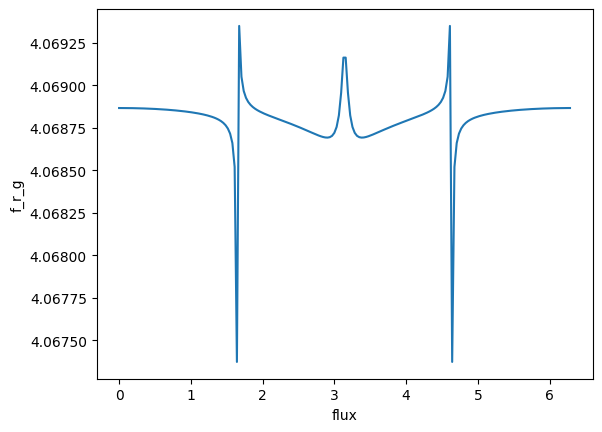

In [9]:
import matplotlib.pyplot as plt
EC, EL, EJ = 1.0, 0.5, 5.3
fr = 4.07
g  = 0.067
flux_list=np.linspace(0,2*np.pi,200)
f_r_g=[]
f_r_e=[]
for phi_ext in flux_list:
    out=readout_frequencies(EC, EL, EJ, phi_ext, fr, g, q_levels=15, N_phot=10)
    f_r_g.append(out['fr_g'])
    f_r_e.append(out['fr_e'])
plt.plot(flux_list,f_r_g)
plt.xlabel('flux')
plt.ylabel('f_r_g')

In [11]:
import numpy as np

def _local_linear_slope(x, y, x0, halfwidth):
    """Fit y ≈ a*(x-x0) + b on [x0-halfwidth, x0+halfwidth]; return slope a."""
    lo, hi = x0 - halfwidth, x0 + halfwidth
    mask = (x >= lo) & (x <= hi)
    xx, yy = x[mask], y[mask]
    if len(xx) < 3:
        return np.nan
    u = xx - x0
    a, b = np.polyfit(u, yy, 1)   # slope, intercept
    return float(a)

def _symmetry_score(x, y, c, halfwidth, n_pairs, eps=1e-12):
    """
    Symmetry score at center c:
        score = RMS_{j} [ y(c+Δ_j) - y(c-Δ_j) ] / scale
    where Δ_j are n_pairs offsets in (0, halfwidth], and y is linearly interpolated.
    """
    # build offsets that are available on both sides within data range
    Δmax = min(c - x[0], x[-1] - c, halfwidth)
    if Δmax <= 0:
        return np.inf
    Δ = np.linspace(Δmax/n_pairs, Δmax, n_pairs)

    yp = np.interp(c + Δ, x, y)
    ym = np.interp(c - Δ, x, y)

    r = yp - ym
    rms = np.sqrt(np.mean(r*r))

    # robust scale for normalization (MAD over data)
    med = np.median(y)
    mad = np.median(np.abs(y - med)) + eps
    return float(rms / mad)

def find_even_centers_with_flatness(
        I, fr_g,
        halfwidth_sym=None,    # window half-width for symmetry (same units as I)
        n_pairs=25,
        halfwidth_slope=None,  # window half-width for slope fit
        slope_tol=None,        # |slope| threshold; if None => data-driven
        score_rel_drop=0.25,   # how deep a local min must be vs neighbors
        max_candidates=8
    ):
    """
    Return centers where the curve is most even AND locally flat (|slope| small).

    Parameters
    ----------
    I : (N,) array_like
        Monotone current/flux samples (unknown offset/period fine).
    fr_g : (N,) array_like
        Measured resonator feature vs I (use magnitude branch).
    halfwidth_sym : float, optional
        Half-width around candidate centers for symmetry check.
        Default: 10% of span(I).
    n_pairs : int
        Number of mirrored pairs for the symmetry score.
    halfwidth_slope : float, optional
        Half-width for linear slope fit. Default: 5% of span(I).
    slope_tol : float, optional
        Absolute slope threshold. If None, set to 0.25 * median|dy/dx|.
    score_rel_drop : float
        Candidate local minima must be at least this fraction lower than a
        simple 5-point neighborhood average.
    max_candidates : int
        Keep at most this many top (lowest-score) candidates before slope filter.

    Returns
    -------
    result : dict with keys
        - 'picked'      : list of dicts {center, score, slope}
        - 'candidates'  : (before slope filter) list of dicts {center, score, slope}
        - 'status'      : 'ok' or message
        - 'notes'       : list of strings describing thresholds used
    """
    x = np.asarray(I, float)
    y = np.asarray(fr_g, float)
    N = len(x)
    if N < 7 or np.any(~np.isfinite(x)) or np.any(~np.isfinite(y)):
        return dict(picked=[], candidates=[], status="bad_input", notes=["non-finite or too short"])

    # defaults for windows
    span = x[-1] - x[0]
    if halfwidth_sym   is None: halfwidth_sym   = 0.10 * span
    if halfwidth_slope is None: halfwidth_slope = 0.05 * span

    # data-driven slope tolerance if not provided
    # estimate derivative with central differences
    dx = np.gradient(x)
    dy = np.gradient(y, x)
    med_abs_slope = np.median(np.abs(dy[np.isfinite(dy)]))
    if slope_tol is None:
        slope_tol = 0.25 * (med_abs_slope if med_abs_slope > 0 else 1.0)

    # compute symmetry score on a coarse grid of candidate centers
    # (use every point but we’ll smooth to avoid noise)
    scores = np.empty(N, float)
    for k in range(N):
        scores[k] = _symmetry_score(x, y, x[k], halfwidth_sym, n_pairs)

    # find local minima of the score (simple 5-point neighborhood)
    winsize = 5
    halfw = winsize // 2
    candidates = []
    for k in range(halfw, N - halfw):
        local_avg = np.mean(scores[k - halfw:k + halfw + 1])
        if scores[k] <= (1.0 - score_rel_drop) * local_avg:
            c = x[k]
            slope = _local_linear_slope(x, y, c, halfwidth_slope)
            candidates.append(dict(center=c, score=scores[k], slope=slope))

    # keep best few by score before flatness filter
    candidates = sorted(candidates, key=lambda d: d["score"])[:max_candidates]

    # apply flatness (|slope| <= tol)
    picked = [c for c in candidates if np.isfinite(c["slope"]) and abs(c["slope"]) <= slope_tol]

    notes = [
        f"halfwidth_sym={halfwidth_sym:.3g}",
        f"halfwidth_slope={halfwidth_slope:.3g}",
        f"slope_tol={slope_tol:.3g} (data-driven 0.25*median|dy/dx|)",
        f"score_rel_drop={score_rel_drop}",
        f"n_pairs={n_pairs}",
        f"span={span:.3g}, N={N}",
    ]
    status = "ok" if picked else "no_flat_even_center_found"

    return dict(picked=picked, candidates=candidates, status=status, notes=notes)


In [12]:
# I : your current/flux array (unknown offset is fine; just monotone)
# fr_g : your measured f_r,g vs I (magnitude branch)

res = find_even_centers_with_flatness(flux_list, f_r_g)

print(res["status"])
for c in res["picked"]:
    print(f"center ≈ {c['center']:.6g}, score={c['score']:.3e}, slope={c['slope']:.3e}")

# If multiple centers are returned, you can:
#  - pick the one with the smallest score,
#  - or cross-check with the phase branch (run the same function on phase data),
#  - or pick the center whose neighborhood gives the highest overall SNR.


ok
center ≈ 6.22004, score=5.975e-03, slope=7.300e-06
center ≈ 0.0631476, score=5.975e-03, slope=-7.300e-06
